In [122]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# ignore warnings

# load data

groupA_train = pd.read_csv('featuresGroupAlearning.csv')
groupB_train = pd.read_csv('featuresGroupBlearning.csv')

groupA_test = pd.read_csv('featuresGroupAprediction.csv')
groupB_test = pd.read_csv('featuresGroupBprediction.csv')
# combine data from two databases
learning = groupB_train.set_index('id').join(groupA_train.set_index('id')).sort_index()
test = groupB_test.set_index('id').join(groupA_test.set_index('id')).sort_index()
learning_y = pd.read_csv('responselearning.csv').set_index('id').sort_index()

In [2]:
learning_y['y'].value_counts() # imbalance

0    10806
1     1267
Name: y, dtype: int64

In [1]:
# test.head()

In [2]:
# learning.head()

In [5]:
# float + few uniques --> ordinal b13,b14,b39,a12,a14 depends on business
# object + --> string b58: month ordinal,b34 weekday,b35,b21,b00
# zip code transfer to two columns --> maybe (x,y), or transform to states; depends on business

### Cleaning

In [123]:
# clean b58 month
month = {}
for m in learning['b58'].unique():
    try:
        month[m]=m.lower().replace('.','')[0:3]
        if month[m]=='api':
            month[m]='apr'
    except:
        pass
for m in test['b58'].unique():
    try:
        month[m]=m.lower().replace('.','')[0:3]
        if month[m]=='api':
            month[m]='apr'        
    except:
        pass
learning['b58'] = learning['b58'].replace(month)
test['b58'] = test['b58'].replace(month)

# clean b34 week
week = {}
for w in learning['b34'].unique():
    try:
        week[w]=w.lower().replace('.','')[0:3]
    except:
        pass
for w in test['b34'].unique():
    try:
        week[w]=w.lower().replace('.','')[0:3]
    except:
        pass
for w in week:
    if week[w]=='teu':
        week[w]='tue'
    if week[w]=='wen':
        week[w]='wed'
learning['b34'] = learning['b34'].replace(week)
test['b34'] = test['b34'].replace(week)

# clean b35 perc
perc = {}
for p in learning['b35'].unique():
    try:
        perc[p]=float(p.replace('%',''))
    except:
        pass
for p in test['b35'].unique():
    try:
        perc[p]=float(p.replace('%',''))
    except:
        pass
learning['b35'] = learning['b35'].replace(perc)
test['b35'] = test['b35'].replace(perc)

# cleaning b00, remove $ and transform to numeric
learning['b00'] = learning['b00'].str.replace(r"^\$",'', regex=True).convert_objects(convert_numeric=True)
test['b00'] = test['b00'].str.replace(r"^\$",'', regex=True).convert_objects(convert_numeric=True)

# zip code

# B21 "central" "west" "East" don't have correlation with zip
# zip code bin to state or logitude/latitude or city size,central/west/east depends on biz
# assumption: slight change in location won't influence much

# # !pip install uszipcode
# solve zip code =>Discretization
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database
for i in learning['zip'].index:
    state = search.by_zipcode(learning.loc[i,'zip']).to_dict()['state']
    if state:
        learning.loc[i,'zip'] = state
    else:
        learning.loc[i,'zip'] = np.nan
for i in test['zip'].index:
#     pdb.set_trace()
    state = search.by_zipcode(test.loc[i,'zip']).to_dict()['state']
#     print(state==None)
    if state!=None:
        test.loc[i,'zip'] = state
    else:
        test.loc[i,'zip']= 'None'
test['zip'].replace("None",np.nan)

cat_cols = ['b58','b34','b35','b21','b13','b14','b39','a12','a14','code','zip']
cont_cols = list(set(learning.columns)-set(cat_cols))

### look at data info

In [10]:
print("Categorical Variables: {}, Continuous Variables:{}".format(len(cat_cols),len(cont_cols)))

Categorical Variables: 11, Continuous Variables:68


In [14]:
learning[cont_cols].head()

,b52,b07,b47,a00,b32,b12,b01,b27,b15,b24,a05,b45,b23,b26,a07,a06,b51,b25,b22,b11,b37,b38,b55,b20,b00,b44,b28,b41,b53,a08,b36,b18,b30,b29,b33,b43,b19,a11,b06,a01,b57,b16,b49,b46,a02,b56,a17,b05,b17,b04,b03,b54,a10,b40,a16,b08,b48,b02,a13,b31,a15,b10,a09,a04,a03,b50,b42,b09
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000-46,-64.384522,851.0,2.945763,480.0,-2.312037,43.836931,14.838814,9.230083,34.430043,4.498217,15.928078,-24.237362,-5.854463,-3.476818,-1.095640,4.958067,0.816508,791.0,41.214702,-0.190767,-55.740135,-10.285967,-10.399261,14.652331,-179.05,-0.727726,2.645743,-16.377785,-4.427883,36.025139,0.406033,-21.447456,-7.645321,3.047373,43.90,-10.015227,4.652129,11.091465,-8.317868,-85.09,8.525860,28.868071,34.749066,8.177379,13.986316,4.524970,-9.770204,-10.132810,15.274145,29.450265,-55.876743,-13.556644,-10.644336,-0.344525,-20.862559,-1.039654,36.54,28.422992,-1.895166,-22.296907,755.0,11.244569,34.760407,-0.757053,-18.484686,72.302904,-11.594089,14.164489
1001-29,37.666092,656.0,-8.700703,712.0,1.431917,-31.946287,-2.164662,10.246129,-2.435067,-0.691180,41.179466,-16.974943,-2.419538,-6.238686,-1.144710,-1.943532,5.533084,954.0,28.379895,7.583415,-12.803193,-7.552637,-8.939575,-2.959406,67.70,10.296552,-14.317019,3.540454,-10.961241,18.001743,4.172692,-16.178333,-28.293492,10.693813,-23.55,-8.718579,5.422160,-8.423604,26.469578,79.67,6.173258,-3.994500,8.089327,17.099919,13.985542,0.448996,-1.288480,-7.343958,-7.830438,18.781212,0.606945,76.176355,-9.140670,1.567580,-14.734940,-5.865822,70.96,28.901448,-7.430692,-2.861515,711.0,-2.766045,-10.324350,-35.065601,-13.835987,18.160249,-16.206638,13.192245
1001-77,-69.160812,692.0,-2.637349,355.0,-12.691694,-46.829226,-8.230810,12.030270,4.282571,1.887015,21.485363,12.452773,-2.970784,-1.274113,-1.642173,-13.047319,-1.217068,1021.0,-11.311869,-12.849796,48.018590,-18.915249,-8.179395,17.069504,405.09,-4.253498,-13.369047,0.125302,-21.945196,-0.773037,14.258658,-7.870666,-13.060908,1.394599,-13.38,-15.464625,8.295654,-8.378788,25.268412,25.59,9.543286,6.136672,-19.992597,17.057074,13.602533,2.050177,-6.818612,0.215387,-24.168662,20.086073,31.276826,12.095990,-12.282192,0.843830,-12.303471,-0.156393,16.71,20.324560,-13.350714,13.069063,838.0,5.309652,7.092145,12.725521,-13.923995,22.850719,-19.075010,11.325995
1002-73,63.461019,423.0,-6.146369,641.0,-7.766379,-11.581529,31.781108,9.994060,-4.624934,3.040520,14.094273,8.236477,-3.949114,-9.482016,-1.501541,-27.251918,-3.589527,841.0,33.338910,5.708988,-28.877973,-16.199399,-16.737133,-59.878984,951.36,-0.446754,1.444140,0.200734,-14.505296,3.196389,21.810180,-5.586210,-16.899286,1.494515,78.35,-6.902708,-2.237148,-4.349782,8.038479,13.48,-0.101116,19.561875,-14.737681,18.743175,13.685529,-4.705142,-2.425501,-13.023984,-1.658673,22.227423,30.821474,-101.864166,-10.652116,3.289492,10.791766,-2.492849,9.53,-52.542084,-6.023346,-4.844802,1013.0,-0.112170,10.402905,-25.739523,-7.498361,40.617678,-13.226941,7.637173
1002-88,7.531435,555.0,-9.576703,603.0,-5.759907,19.214385,2.874900,12.143091,-20.854148,-1.169207,4.508749,-9.490450,-3.051016,-3.836641,-1.695467,-28.281144,-1.326674,761.0,-38.034588,-2.231804,11.754414,-6.666766,-6.339236,5.064626,106.82,20.302694,-9.844025,-11.661924,-3.285331,-2.084332,9.823116,-1.900948,-8.409761,3.518548,57.95,-19.988951,8.491587,2.843109,0.765912,21.26,5.425221,19.907279,5.463797,10.096187,14.822186,-1.584388,-4.352697,-9.062064,-13.223060,18.198124,-36.404942,5.764182,-14.543130,2.523994,-34.483187,-9.959902,49.70,-18.723858,-11.601557,-1.711605,579.0,3.669908,-2.007566,-33.028198,-5.588599,56.509045,-12.303340,3.947852


In [16]:
learning[cat_cols+['b00']].head()

,b58,b34,b35,b21,b13,b14,b39,a12,a14,code,zip,b00
id,,,,,,,,,,,,
1000-46,jun,wed,0.01,Central,5.0,7.0,3.0,5.0,7.0,1000002.0,TX,-179.05
1001-29,sep,wed,-0.00,Central,4.0,6.0,5.0,5.0,4.0,1000009.0,NaN,67.70
1001-77,aug,tue,0.01,Central,5.0,7.0,4.0,2.0,4.0,1000002.0,FL,405.09
1002-73,sep,thu,0.01,Central,6.0,7.0,5.0,5.0,6.0,1000003.0,NY,951.36
1002-88,jul,thu,0.00,East,5.0,6.0,7.0,6.0,6.0,1000007.0,FL,106.82


In [102]:
learning[cat_cols].astype(str).describe()
# too many invalid zip codes: None into one unkown group, or impute by other columns, or don't use zip code

,b58,b34,b35,b21,b13,b14,b39,a12,a14,code,zip
count,12073,12073,12073,12073,12073,12073,12073,12073,12073,12073,12073
unique,13,6,11,4,9,10,12,8,11,11,52
top,jul,wed,0.01,Central,5.0,6.0,6.0,4.0,6.0,1000009.0,nan
freq,3354,6277,3000,10723,4424,4049,3530,4862,3975,3771,7074


In [103]:
test[cat_cols].astype(str).describe()

,b58,b34,b35,b21,b13,b14,b39,a12,a14,code,zip
count,5366,5366,5366,5366,5366,5366,5366,5366,5366,5366,5366
unique,13,6,10,4,9,8,12,9,9,11,52
top,jul,wed,0.01,Central,5.0,6.0,6.0,4.0,6.0,1000009.0,None
freq,1478,2689,1306,4771,1976,1844,1558,2151,1756,1663,3164


In [104]:
learning[cont_cols].astype(float).describe()

,b48,b29,a00,b52,b05,b10,b47,b25,b42,b49,b02,a06,b16,a17,b09,b51,b30,b17,b01,b36,a03,b54,b28,a05,b11,b57,b08,b23,b26,b04,b45,a01,b00,b33,b53,b06,a10,b44,b37,b24,b40,a11,a07,b41,b50,a04,b32,b20,a13,b19,a16,a02,b55,b43,a08,b27,b18,b38,b12,b07,a09,b03,b22,b46,b31,a15,b56,b15
count,12072.000000,12073.000000,12069.000000,12072.000000,12066.000000,12070.000000,12071.000000,12073.000000,12071.000000,12071.000000,12071.000000,11951.000000,12072.000000,11931.000000,12069.000000,12069.000000,12071.000000,12072.000000,12067.000000,12072.000000,11944.000000,12070.000000,12071.000000,11952.000000,12072.000000,12070.000000,12070.000000,12071.000000,12072.000000,12071.000000,12069.000000,12073.000000,12070.000000,12071.000000,12072.000000,12072.000000,11971.000000,12071.000000,12067.000000,12069.000000,12069.000000,11937.000000,11936.000000,12072.000000,12071.000000,11940.000000,12071.000000,12072.000000,11960.000000,12070.000000,11945.000000,11945.000000,12069.000000,12070.000000,11958.000000,12072.000000,12072.000000,12071.000000,12070.000000,12070.000000,11967.000000,12071.000000,12073.000000,12070.000000,12072.000000,12068.000000,12071.000000,12070.000000
mean,-2.709709,1.473392,561.632778,9.206761,-11.333195,1.173526,-5.237765,844.507579,-12.914364,-2.083817,-4.070063,-8.247427,0.633953,-4.272962,7.366043,-1.586969,-13.029130,1.705548,6.634024,13.965411,-7.885285,-14.772450,-4.564066,8.309043,1.368057,6.955793,-3.712574,-3.557976,-6.877896,13.199711,5.344691,-2.054970,51.212611,15.118926,-12.070330,12.780397,-11.392910,7.228239,-4.137898,4.165093,-0.656484,-3.237990,-1.427633,-2.814072,10.682501,-6.782323,-7.655604,5.622847,-8.931390,0.499542,-8.261965,13.803515,-10.639874,-12.735170,3.872616,11.645971,-9.029095,-8.290096,1.107837,617.187407,-7.268221,0.876233,-0.815834,12.199649,-0.550779,766.832367,-0.114662,-0.127879
std,55.589842,3.563347,136.859206,45.572486,5.345741,8.145074,5.979180,189.263117,2.508217,19.756764,30.930414,14.829748,19.296810,6.674128,4.165467,8.809272,8.461674,17.519692,24.203818,5.971180,8.193092,46.146956,8.715993,22.006536,7.037907,3.254707,4.962276,1.632595,3.735526,22.422198,19.412547,54.354379,992.608989,53.645265,7.911383,8.777613,2.788808,5.890866,25.055588,2.915478,3.396022,10.102343,0.249234,14.190059,35.997242,28.061147,5.370257,25.758307,5.968127,14.858055,31.895540,0.600911,2.746379,5.035469,18.287513,1.612605,16.627421,17.826682,24.149899,123.617267,13.254469,36.657320,33.131307,5.659551,17.485419,166.884130,2.632227,15.168822
min,-191.460000,-12.107680,22.000000,-200.763293,-32.998805,-33.190202,-28.903684,34.000000,-22.308152,-85.469764,-136.119703,-67.024743,-78.906055,-29.250145,-8.490536,-31.908783,-49.557431,-65.432852,-95.853505,-11.718860,-39.360198,-189.750449,-37.656632,-72.695307,-24.054399,-4.885243,-23.361907,-9.797452,-21.200585,-70.604065,-74.556572,-224.430000,-3737.110000,-194.850000,-41.786730,-23.888320,-22.225504,-13.711069,-96.574794,-6.066645,-13.758002,-40.048635,-2.390651,-64.119123,-110.957048,-119.137115,-28.556956,-94.766226,-32.281128,-54.623074,-139.412636,11.516421,-21.610297,-30.323840,-64.772105,5.695753,-71.481427,-80.740510,-94.722931,123.000000,-62.021965,-150.085633,-119.663583,-9.119130,-64.342025,51.000000,-10.320102,-61.439890
25%,-40.510000,-0.951232,469.000000,-21.804950,-14.930570,-4.345833,-9.305310,727.000000,-14.629235,-15.316688,-24.637011,-18.217447,-12.222382,-8.842228,4.570060,-7.534572,-18.728971,-10.225631,-9.654632,9.944482,-13.461179,-45.365597,-10.472554,-6.475821,-3.396390,4.787530,-7.118410,-4.652945,-9.426257,-1.833472,-7.522759,-38.080000,-615.162500,-21.540000,-17.432717,6.803319,-13.257489,3.262783,-21.000363,2.194226,-2.965297,-10.061720,-1.597758,-12.353737,-13.753435,-26.160891,-11.285479,-11.733620,-12.987286,-9.481071,-29.630777,13.400547,-12.502459,-16.151840,-8.366976,10.550816,-20.219019,-20.233935,-15.313643,535.000000,-16.084297,-23.781799,-23.198007,8.307053,-12.364760,657.000000,-1.877296,-10.252615
50%,-3.350000,1.505499,561.00

In [105]:
test[cont_cols] = test[cont_cols].astype(float)
test[cont_cols].describe()

,b48,b29,a00,b52,b05,b10,b47,b25,b42,b49,b02,a06,b16,a17,b09,b51,b30,b17,b01,b36,a03,b54,b28,a05,b11,b57,b08,b23,b26,b04,b45,a01,b00,b33,b53,b06,a10,b44,b37,b24,b40,a11,a07,b41,b50,a04,b32,b20,a13,b19,a16,a02,b55,b43,a08,b27,b18,b38,b12,b07,a09,b03,b22,b46,b31,a15,b56,b15
count,5365.000000,5366.000000,5363.000000,5364.000000,5364.000000,5365.000000,5366.000000,5366.000000,5363.000000,5365.000000,5366.000000,5311.000000,5366.000000,5314.000000,5364.000000,5365.000000,5363.000000,5366.000000,5364.000000,5363.000000,5319.000000,5364.000000,5364.000000,5304.000000,5366.000000,5366.000000,5364.000000,5365.000000,5365.000000,5366.000000,5366.000000,5362.000000,5366.000000,5366.000000,5364.000000,5364.000000,5312.000000,5364.000000,5365.000000,5365.000000,5364.000000,5313.000000,5309.000000,5361.000000,5366.000000,5305.000000,5366.000000,5366.000000,5313.000000,5365.000000,5318.000000,5312.000000,5366.000000,5366.000000,5306.000000,5364.000000,5365.000000,5366.000000,5365.000000,5366.000000,5310.000000,5366.000000,5365.000000,5366.000000,5364.000000,5364.000000,5366.000000,5365.000000
mean,-2.622598,1.402952,564.682081,9.246877,-11.323537,1.290695,-5.347239,848.000559,-12.965198,-2.159120,-3.406885,-8.326199,1.069156,-4.383317,7.360882,-1.528859,-12.915902,1.625752,6.814084,13.971550,-8.042009,-13.551739,-4.260184,8.222657,1.545982,7.039379,-3.598654,-3.569271,-6.875860,13.621992,5.152064,-2.495257,34.528312,14.494842,-12.172322,12.740374,-11.395958,7.473329,-4.337266,4.246419,-0.697834,-2.985998,-1.430161,-2.890360,10.332532,-6.247762,-7.609017,5.533714,-9.043877,0.138258,-8.063767,13.802074,-10.704659,-12.666602,4.310042,11.619904,-8.802862,-8.228809,0.118374,617.685240,-7.063564,1.005604,-0.604295,12.303212,-0.426365,771.872297,-0.081458,-0.240183
std,55.704445,3.505452,140.003732,46.418757,5.414316,8.103842,6.017648,189.073743,2.507002,19.534573,31.307083,14.512681,19.792245,6.625178,4.156679,8.784276,8.361495,17.708814,24.122205,5.978090,8.134285,45.898797,8.812972,22.064546,7.207082,3.214235,4.905197,1.654014,3.773136,22.559709,19.430530,54.494968,985.678705,53.903000,7.858171,8.541526,2.856440,5.871483,24.720943,2.857749,3.327980,10.247851,0.253392,14.067254,35.770248,27.440568,5.357557,25.600208,5.976836,14.922695,31.570491,0.604137,2.712781,4.955531,18.366815,1.640408,16.516060,17.692708,24.012778,124.671093,13.443694,36.668536,33.061140,5.527039,17.527452,169.299140,2.635413,15.055712
min,-181.830000,-12.639877,59.000000,-163.734568,-32.576069,-29.649696,-27.606973,17.000000,-21.053749,-80.408015,-112.988496,-59.883121,-83.465756,-27.372766,-8.219007,-35.396732,-41.632091,-59.989018,-83.029544,-9.710754,-35.769201,-171.782348,-40.124275,-82.140515,-23.876454,-4.381603,-23.239790,-9.218973,-19.752033,-82.474639,-67.350644,-195.770000,-3409.530000,-189.900000,-42.494163,-15.470573,-22.512354,-11.861093,-88.718685,-6.058382,-12.850347,-41.898909,-2.280655,-56.897713,-102.281484,-101.732857,-26.670030,-110.139462,-30.499477,-58.713915,-144.280360,10.995877,-21.705460,-30.671018,-74.476423,5.430239,-68.735979,-68.064326,-82.202065,215.000000,-57.734452,-150.135392,-108.506901,-6.572966,-60.909708,0.000000,-10.209884,-66.898889
25%,-39.960000,-0.977563,470.000000,-22.102612,-14.891164,-4.259912,-9.477003,729.000000,-14.645228,-15.520995,-24.427178,-18.226879,-12.214969,-8.891694,4.530189,-7.445086,-18.603319,-10.282554,-9.188920,9.867591,-13.545785,-44.134918,-10.269209,-6.472819,-3.373201,4.859044,-6.903136,-4.658315,-9.508835,-1.509986,-7.648781,-39.220000,-633.730000,-21.477500,-17.396863,7.099240,-13.344407,3.561972,-21.053023,2.300899,-3.024557,-9.920060,-1.601615,-12.221643,-13.337298,-24.703142,-11.267169,-11.766923,-13.165586,-9.948360,-29.470405,13.403494,-12.516328,-16.040379,-8.045596,10.504270,-20.043670,-20.006289,-16.247825,532.000000,-15.920747,-22.956763,-22.696505,8.561080,-12.427983,662.000000,-1.902855,-10.232866
50%,-3.450000,1.431261,565.000000,8.016434,-11.261088,1.357980,-5.341775,854.000000,-12.956297,-2.3

In [13]:
# check missing numbers
learning.isna().sum().describe() # max missing 142 in 12073

count      79.000000
mean      111.936709
std       794.644257
min         0.000000
25%         1.500000
50%         3.000000
75%         4.500000
max      7074.000000
dtype: float64

In [14]:
test.isna().sum().describe() # max missing 62 in 5366

count    79.000000
mean      9.936709
std      20.130562
min       0.000000
25%       0.000000
50%       1.000000
75%       2.500000
max      62.000000
dtype: float64

### Fill Missing Value

In [124]:
# drop zip
learning = learning.drop(['zip'],axis=1)
test = test.drop(['zip'],axis=1)
cat_cols.pop()

# fill missing value by mode
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


learning[cat_cols] = imp_mode.fit_transform(learning[cat_cols].values)
test[cat_cols] = imp_mode.fit_transform(test[cat_cols].values)


imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
learning[cont_cols] = imp_mean.fit_transform(learning[cont_cols].values)
test[cont_cols] = imp_mean.fit_transform(test[cont_cols].values)
# iterative imputer????
# does mode make senses?
# depends on business

# learning[cat_cols] = learning[cat_cols].astype(str)
# test[cat_cols] = test[cat_cols].astype(str)
learning[cont_cols] = learning[cont_cols].astype(float)
test[cont_cols] = test[cont_cols].astype(float)

### Plot data

In [15]:
learning_categorical = learning[cat_cols]
learning_categorical.to_csv('learning_cat.csv')

learning_continuous = learning[cont_cols]
learning_continuous.to_csv('learning_cont.csv')
# go tableau

In [107]:
# !pip install seaborn

In [108]:
# import seaborn as sns
# sns_plot = sns.pairplot(learning.head(1000),size=2.0)
# sns_plot.savefig("pairplot.png")
# # too slow, too many rows

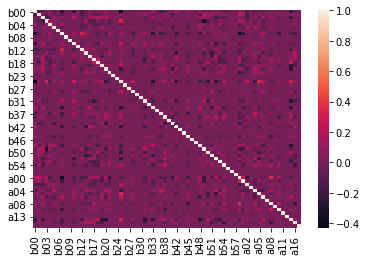

In [17]:
# correlation
corr_matrix = learning.corr()
sns.heatmap(corr_matrix)


In [27]:
(corr_matrix>0.8).sum() # no correlated columns to eliminate

b00    0
b01    0
b02    0
b03    0
b04    0
b05    0
b06    0
b07    0
b08    0
b09    0
b10    0
b11    0
b12    0
b15    0
b16    0
b17    0
b18    0
b19    0
b20    0
b22    0
b23    0
b24    0
b25    0
b26    0
b27    0
b28    0
b29    0
b30    0
b31    0
b32    0
b33    0
b36    0
b37    0
b38    0
b40    0
b41    0
b42    0
b43    0
b44    0
b45    0
b46    0
b47    0
b48    0
b49    0
b50    0
b51    0
b52    0
b53    0
b54    0
b55    0
b56    0
b57    0
a00    0
a01    0
a02    0
a03    0
a04    0
a05    0
a06    0
a07    0
a08    0
a09    0
a10    0
a11    0
a13    0
a15    0
a16    0
a17    0
dtype: int64

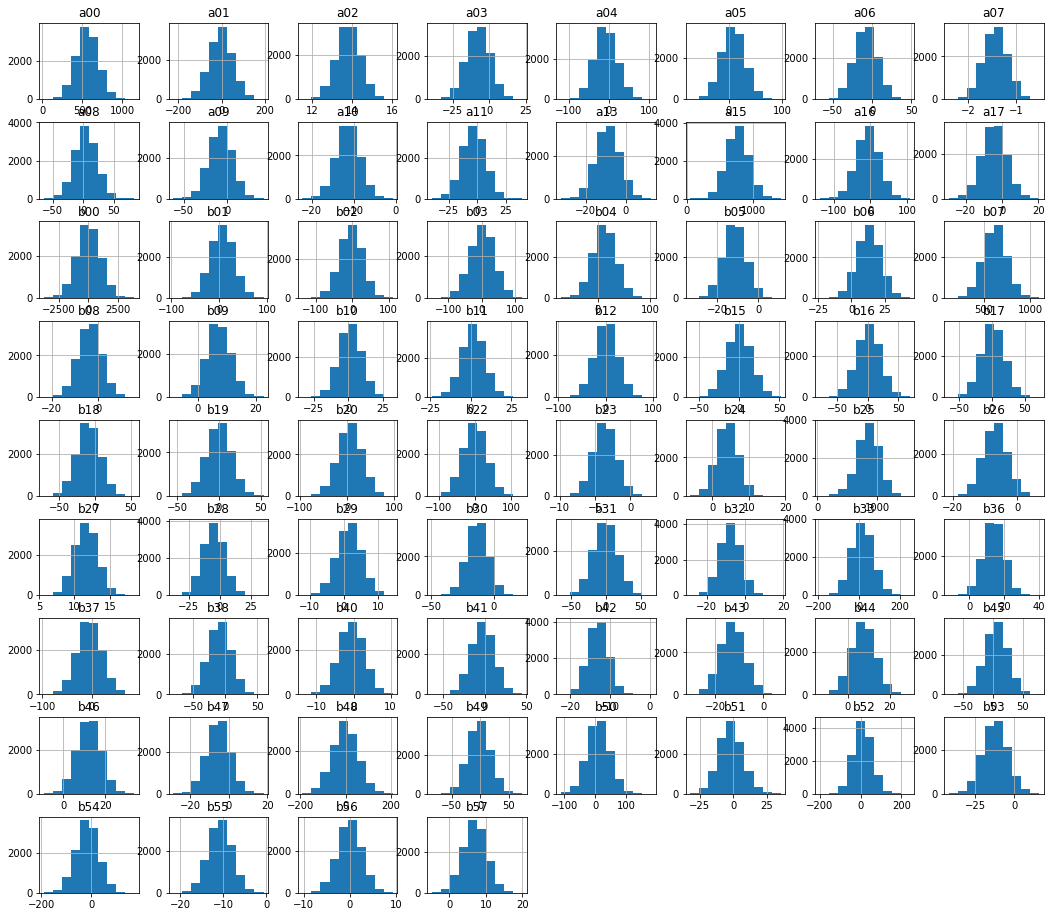

In [13]:
from matplotlib import pyplot as plt
learning[cont_cols].hist(figsize=(18, 16))
plt.show()

### Encode
encoder categorical variables
didn't do standarlization, tree could handle differnt scale, don't change distribution

In [125]:
from sklearn.preprocessing import OrdinalEncoder
cate_order = []
enc = OrdinalEncoder()
enc.fit(pd.concat([learning[cat_cols],test[cat_cols]]))
enc.categories_[0] = np.array(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov', 'dec'])
enc.categories_[1] = np.array(['mon','tue','wed','thu','fri'])
enc.categories_[3] = np.array(['East','Central','West'])
learning[cat_cols] = enc.transform(learning[cat_cols])
test[cat_cols] = enc.transform(test[cat_cols])
enc.categories_

[array(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep',
        'oct', 'nov', 'dec'], dtype='<U3'),
 array(['mon', 'tue', 'wed', 'thu', 'fri'], dtype='<U3'),
 array([-0.04, -0.03, -0.02, -0.01, -0.0, 0.01, 0.02, 0.03, 0.04],
       dtype=object),
 array(['East', 'Central', 'West'], dtype='<U7'),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0], dtype=object),
 array([2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0],
       dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0], dtype=object),
 array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], dtype=object),
 array([1000000.0, 1000001.0, 1000002.0, 1000003.0, 1000004.0, 1000005.0,
        1000006.0, 1000007.0, 1000008.0, 1000009.0], dtype=object)]

### Train Valid Split

train for training by different models


val for compare their performance

In [105]:
# sampling for index
msk = np.random.rand(len(learning)) < 0.8

train = learning[msk]

val = learning[~msk] 

train_y = learning_y[msk]

val_y = learning_y[~msk]


In [44]:
val.to_csv("test_2.csv")
val_y.to_csv("test_2_y.csv")

## Three Models: SVM, Lgbm, RandomForest

In [99]:
train_svm= train.copy()
train_lgbm= train.copy()
train_rf =train.copy()

val_svm= val.copy()
val_lgbm= val.copy()
val_rf= val.copy()

train_svm_y= train_y.copy()
train_lgbm_y= train_y.copy()
train_rf_y =train_y.copy()

### SVM(Baseline)

In [64]:
# # Normalize data
# # remove outliers
# from scipy import stats
# z = stats.zscore(train_svm[cont_cols])
# outliers=train_svm.index[np.where(np.abs(z)>3.5)[0] ]# outlier index

# train_svm = train_svm.drop(outliers,axis=0)
# train_svm_y = train_svm_y.drop(outliers,axis=0)

# from sklearn import preprocessing
# # scale for continuous values
# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(train_svm[cont_cols])

# train_svm[cont_cols] = scaler.transform(train_svm[cont_cols])
# val_svm[cont_cols] = scaler.transform(val_svm[cont_cols])

# After comparing with and without preprocessing, don't remove outliers and normalize data in this case

In [102]:
from sklearn.metrics import roc_auc_score  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.svm import SVC
X_train, X_val, y_train, y_val = train_test_split(  
    train_lgbm,  
    train_lgbm_y,  
    test_size=0.05,  
    #random_state=1,  
    stratify=train_lgbm_y
)

In [103]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
clf = SVC(kernel='poly',probability=True)
clf.fit(X_train, y_train)
roc_auc_score(y_val,clf.predict(X_val))


0.8669658808662687

In [107]:
# performance on validation set
roc_auc_score(val_y,clf.predict(val))

0.8909554730983303

In [80]:
# save model to pickle file
import pickle
pkl_filename = "svm_model_2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)

### Lgbm
Could handle missing values and categorical variables
we have filled missing value coz lgbm method only have NA,0 and don't use missing, whatever depends on business

In [135]:
# !pip install lightgbm

In [25]:
import lightgbm as lgb  
import pandas as pd  
import numpy as np  
import pickle  
from sklearn.metrics import roc_auc_score  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# train_lgbm
# train_lgbm_y
# val_lgbm # test for lgbm

X_train, X_val, y_train, y_val = train_test_split(  
    train_lgbm,  
    train_lgbm_y,  
    test_size=0.05,  
    #random_state=1,  
    stratify=train_lgbm_y
)

In [51]:
final_params = {'cat_smooth': 87,
 'max_cat_threshold': 53,
 'min_data_per_group': 966,
 'learning_rate': 0.08,
 'num_iterations': 4499,
 'scale_pos_weight': 8,
 'colsample_bytree': 0.7699590061293953,
 'min_child_samples': 283,
 'min_child_weight': 10.0,
 'num_leaves': 559,
 'max_bin': 1357,
 'max_depth': 14,
 'min_data_in_leaf': 670,
 'boosting': 'dart',
 'reg_lambda': 3,
 'bagging_fraction': 0.6,
 'feature_fraction': 0.6,
 'scoring': 'roc_auc',
 'metric': 'auc',
 'objective': 'binary'}

# {'cat_smooth': 51,
#  'max_cat_threshold': 92,
#  'min_data_per_group': 989,
#  'learning_rate': 0.09,
#  'num_iterations': 2103,
#  'scale_pos_weight': 9,
#  'colsample_bytree': 0.9606744424311603,
#  'min_child_samples': 374,
#  'min_child_weight': 10.0,
#  'num_leaves': 2004,
#  'max_bin': 1483,
#  'max_depth': 4,
#  'min_data_in_leaf': 794,
#  'boosting': 'dart',
#  'reg_lambda': 7,
#  'bagging_fraction': 0.6,
#  'feature_fraction': 0.6,
#  'scoring': 'roc_auc',
#  'metric': 'auc',
#  'objective': 'binary'}

[100]	training's auc: 0.954416	valid_1's auc: 0.906976
[200]	training's auc: 0.971688	valid_1's auc: 0.930966
[300]	training's auc: 0.982802	valid_1's auc: 0.943345
[400]	training's auc: 0.989829	valid_1's auc: 0.951658
[500]	training's auc: 0.994073	valid_1's auc: 0.953556
[600]	training's auc: 0.996366	valid_1's auc: 0.96092
[700]	training's auc: 0.997734	valid_1's auc: 0.958616
[800]	training's auc: 0.998514	valid_1's auc: 0.957983
[900]	training's auc: 0.999126	valid_1's auc: 0.960197
[1000]	training's auc: 0.99944	valid_1's auc: 0.959067
[1100]	training's auc: 0.999634	valid_1's auc: 0.961869
[1200]	training's auc: 0.999737	valid_1's auc: 0.960965
[1300]	training's auc: 0.999818	valid_1's auc: 0.960333
[1400]	training's auc: 0.999888	valid_1's auc: 0.962908
[1500]	training's auc: 0.999911	valid_1's auc: 0.963224
[1600]	training's auc: 0.999948	valid_1's auc: 0.963947
[1700]	training's auc: 0.999967	valid_1's auc: 0.963224
[1800]	training's auc: 0.999976	valid_1's auc: 0.963314
[19

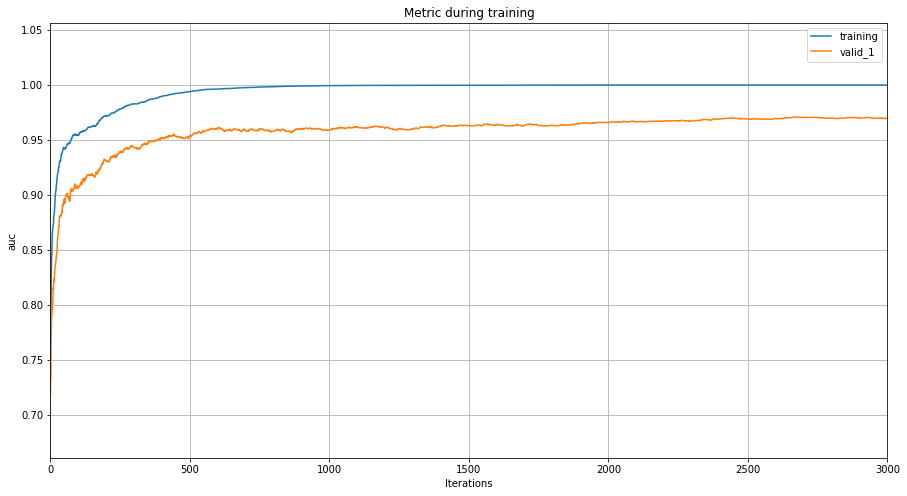

In [59]:
from matplotlib import pyplot as plt
lgbm_train = lgb.Dataset(X_train, y_train, categorical_feature=cat_cols)
lgbm_val = lgb.Dataset(X_val, y_val, reference = lgbm_train)
evals_result = {}  # to record eval results for plotting
model_lgbm = lgb.train(final_params,
                lgbm_train,
                num_boost_round=250,
                valid_sets=[lgbm_train, lgbm_val],
                feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                categorical_feature= [list(learning.columns).index(cat) for cat in cat_cols],
                evals_result=evals_result,
                verbose_eval=100,
                early_stopping_rounds=2)
ax = lgb.plot_metric(evals_result, metric='auc', figsize=(15, 8))
plt.show()

In [60]:
# performance on validation set
from sklearn.metrics import roc_auc_score
roc_auc_score(val_y,model_lgbm.predict(val))

0.9729117835073513

In [36]:
pkl_filename = "lgbm_model_2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_lgbm, file)

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle
rf = RandomForestClassifier()
# random_grid = {'n_estimators':[10, 100],# [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
#                'criterion':['gini', 'entropy'],
#                'max_features': ['auto', 'sqrt'],
# #                'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [2, 4, 8],
#                'bootstrap': [True, False]
#               }
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(  
    train_rf,  
    train_rf_y,  
    test_size=0.05,  
    #random_state=1,  
    stratify=train_rf_y
)

In [38]:
final_params ={'n_estimators': 1800,
 'criterion': 'entropy',
 'min_samples_split': 5,
 'min_samples_leaf': 16,
 'max_features': 'sqrt',
 'max_depth': 24,
 'bootstrap': False}

In [39]:
# initialize classifier with final hyperparameters
rf_final = RandomForestClassifier(**final_params,verbose=20)

In [43]:
pkl_filename = "rf_model_2.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model_rf, file)

### Evaluate and compare

In [130]:
# load validation set
val = pd.read_csv("test_2.csv").set_index('id')
val_y = pd.read_csv("test_2_y.csv").set_index('id')

In [126]:
with open("lgbm_model_2.pkl", 'rb') as file:
    lgbm_model = pickle.load(file)
import pickle
with open("rf_model_2.pkl", 'rb') as file_2:
    rf_model = pickle.load(file_2)

# LightGBM AUC
roc_auc_score(val_y,lgbm_model.predict(val))

0.9770022221545768

In [49]:
# Random forest AUC
roc_auc_score(val_y,rf_model.predict_proba(val)[:,1])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

0.9511944080849898

In [81]:
# load svm model
with open("svm_model_2.pkl", 'rb') as file_2:
    svm_model = pickle.load(file_2)
roc_auc_score(val_y,svm_model.predict(val))

0.8755964430306535

In [82]:
# what if do ensemble on three models
roc_auc_score(val_y,(rf_model.predict_proba(val)[:,1]+lgbm_model.predict(val)+svm_model.predict(val))/3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

0.9768880703783751

### Feature Importance

Feature ranking:
1. 51 (0.058427)
2. 55 (0.053178)
3. 2 (0.038479)
4. 47 (0.031412)
5. 66 (0.029803)
6. 3 (0.027623)
7. 69 (0.023695)
8. 27 (0.023420)


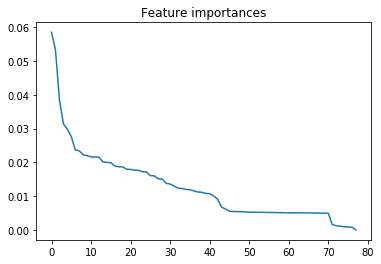

In [28]:
# Random forest
#tree feature importance
#impurity-based feature importances
importances = rf_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_final.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][0:78]

print("Feature ranking:")

for f in range(len(learning.columns[0:8])):
    print("%d. %s (%f)" % (f + 1, indices[f]+1, importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
from matplotlib import pyplot as plt
plt.figure()
plt.title("Feature importances")
# plt.bar(range(len(learning.columns[0:78])), importances[indices],
#          yerr=std[indices], align="center")
plt.plot(range(len(learning.columns[0:78])), importances[indices])
# plt.xticks(range(len(learning.columns[0:18])), learning.columns[indices])
# plt.xlim([-1, len(learning.columns[0:18])])
plt.show()

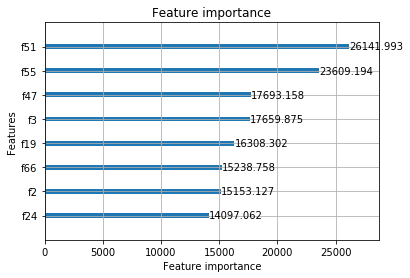

In [27]:
#lgbm importance
import lightgbm
lightgbm.plot_importance(lgbm_model,max_num_features=8,importance_type='gain')
# importance_type (string, optional (default="split")) 
# – How the importance is calculated. 
# If “split”, result contains numbers of times the feature is used in a model. 
# If “gain”, result contains total gains of splits which use the feature.

### Prediction

In [127]:
rf_pred_df= pd.DataFrame(rf_model.predict_proba(test)[:,1])
lgbm_pre_df = pd.DataFrame(lgbm_model.predict(test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [128]:
rf_pred_df['id']=test.index
lgbm_pre_df['id']=test.index

In [121]:
rf_pred_df.to_csv('rf_prediction.csv')
lgbm_pre_df.to_csv('lgbm_prediction.csv')